In [153]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, Conv2D, Dropout, Dense, Flatten

In [154]:
# Read data
data_dir = '../data/processed/track1'
data_df = pd.read_csv(os.path.join(data_dir, 'driving_log.csv'))

data_df.head()

,image_path,steering_angle,throttle,brake,speed
0,data/processed/track1/IMG/center_2024_11_08_18...,0.000,0.0,0,0.000018
1,data/processed/track1/IMG/center_2024_11_08_18...,-0.000,0.0,0,0.000018
2,data/processed/track1/IMG/center_2024_11_08_18...,0.000,0.0,0,0.000018
3,data/processed/track1/IMG/center_2024_11_08_18...,-0.024,0.0,0,0.000018
4,data/processed/track1/IMG/left_2024_11_08_18_2...,0.200,0.0,0,0.000018


/tmp/ipykernel_60824/1479951530.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['image_path'] = "../" + X['image_path']


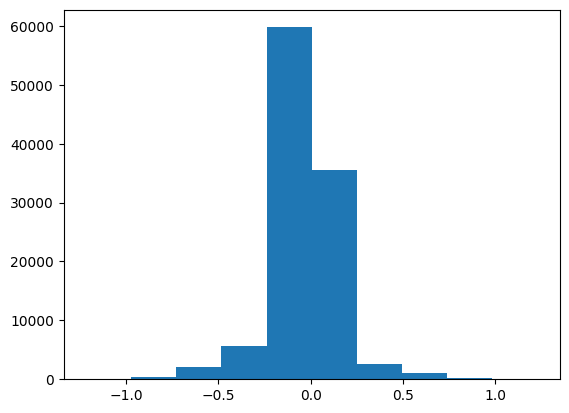

In [155]:
# Take image for training, steering angle for label
X = data_df[['image_path']]#.values
y = data_df['steering_angle'].values

plt.hist(y)


X['image_path'] = "../" + X['image_path']
X = X.values

(array([   91.,   455.,  2038.,  5644., 38497., 35545.,  2558.,  1042.,
          287.,    82.]),
 array([-1.216 , -0.9718, -0.7276, -0.4834, -0.2392,  0.005 ,  0.2492,
         0.4934,  0.7376,  0.9818,  1.226 ]),
 <BarContainer object of 10 artists>)

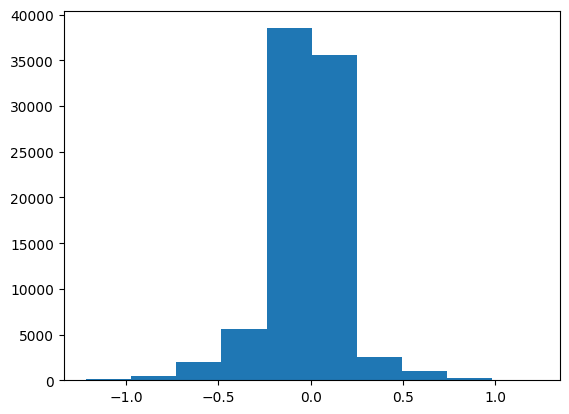

In [156]:
# Remove zero steering angle data, just keep 1000 of them
pos_zero = np.array(np.where(y==0)).reshape(-1, 1)
pos_none_zero = np.array(np.where(y!=0)).reshape(-1, 1)
np.random.shuffle(pos_zero)
pos_zero = pos_zero[:1000]
pos_combined = np.vstack((pos_zero, pos_none_zero))
pos_combined = pos_combined.flatten()

y = y[pos_combined].reshape(len(pos_combined))
X = X[pos_combined, :]

plt.hist(y)


In [ ]:
# Split data into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, \
random_state=0)

In [158]:
# Define model
model = Sequential()
model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(66, 200, 3)))
model.add(Conv2D(24, (5, 5), activation='elu', strides=(2, 2)))
model.add(Conv2D(36, (5, 5), activation='elu', strides=(2, 2)))
model.add(Conv2D(48, (5, 5), activation='elu', strides=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='elu'))
model.add(Conv2D(64, (3, 3), activation='elu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))

model.summary()

/home/norman/Study/Machine Learning/Deep Learning/SelfDrivingCar/.venv/lib/python3.12/site-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_13 (Lambda)              │ (None, 66, 200, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 31, 98, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 3, 20, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 1, 18, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,219 (985.23 KB)

 Trainable params: 252,219 (985.23 KB)

 Non-trainable params: 0 (0.00 B)

In [159]:
nb_epoch = 10
samples_per_epoch = 1000
batch_size = 32
save_best_only = True
learning_rate = 1e-4

In [160]:
# Checkpoint to save the best model after each epoch
checkpoint = ModelCheckpoint(
    filepath='../models/model.keras',
    monitor='val_loss',
    save_best_only=save_best_only,
    mode='auto'
)

In [161]:
# Use mean squared error for loss function and Adam optimizer
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate))

In [162]:
def batch_generator(preprocessed_data_dir, X_train, y_train, batch_size):
    num_samples = len(X_train)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_X_paths = X_train[offset:offset + batch_size]
            batch_y = y_train[offset:offset + batch_size]

            batch_images = []
            batch_labels = []

            for img_path, label in zip(batch_X_paths, batch_y):
                img_path = img_path[0]
                image = cv2.imread(img_path)
                
                if image is None:
                    print(f"Warning: Image at {img_path} could not be read.")
                    continue
                
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                batch_images.append(image)
                batch_labels.append(label)

            batch_images = np.array(batch_images)
            batch_labels = np.array(batch_labels)

            yield batch_images, batch_labels

In [163]:
H = model.fit(
    batch_generator(data_dir + "/IMG", X_train, y_train, batch_size),
    steps_per_epoch=samples_per_epoch,
    epochs=nb_epoch,
    validation_data=batch_generator(data_dir + "/IMG", X_valid, y_valid, batch_size),
    validation_steps=len(X_valid) // batch_size,
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0594 - val_loss: 0.0328
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0344 - val_loss: 0.0290
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0314 - val_loss: 0.0275
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0293 - val_loss: 0.0278
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0281 - val_loss: 0.0267
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0268 - val_loss: 0.0258
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0263 - val_loss: 0.0243
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0259 - val_loss: 0.0240
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0254 - val_loss: 0.0237
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0243 - val_loss: 0.0238
